<a href="https://colab.research.google.com/github/vitorcghub/caseNeon_creditmodel/blob/develop/caseNeon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install optbinning

In [2]:
import pandas as pd
#from optbinning import OptimalBinning
from IPython.display import display
import numpy as np
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Exploração dos Dados

In [4]:
  credit = pd.read_csv('UCI_Credit_Card.csv')

In [ ]:
credit.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [ ]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [ ]:
# features categoricas
credit[['SEX', 'EDUCATION', 'MARRIAGE']].describe()

,SEX,EDUCATION,MARRIAGE
count,30000.000000,30000.000000,30000.000000
mean,1.603733,1.853133,1.551867
std,0.489129,0.790349,0.521970
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000
max,2.000000,6.000000,3.000000


EDUCATION:

1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown

-> Categoria 0 não documentada

MARRIAGE:

1=married, 2=single, 3=others

-> Categoria 0 não documentada

In [ ]:
# features de pagamento
credit[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100
std,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


PAY_N:

-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above

Não está documentado o código -2, e PAY_0 pode se tornar PAY_1 seguindo a padronização dos nomes das outras colunas

In [ ]:
# features de valor da fatura
credit[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


In [ ]:
# features de valor pago de fatura
credit[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


# Limpeza e recategorização

In [5]:
# troca o nome da coluna target e o PAY de 0 para 1
credit.rename(columns={"default.payment.next.month": "IsDef",
                    'PAY_0': 'PAY_1'}, inplace=True)

In [ ]:
credit[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100
std,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


In [ ]:
# credit[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']] = credit[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].apply(lambda x: 5 if x in [0, 6] else x)

In [6]:
# recategoriza feature de educação
credit['EDUCATION'] = credit['EDUCATION'].apply(lambda x: 5 if x in [0, 6] else x)

In [7]:
# recategoriza feature de estado civil
credit['MARRIAGE'] = credit['MARRIAGE'].replace(0, 3)

# Análise Bivariada (Numéricas)

In [ ]:
credit.columns

In [ ]:
num = ['LIMIT_BAL', 'AGE', 'BILL_AMT1',
        'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
        'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
        'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


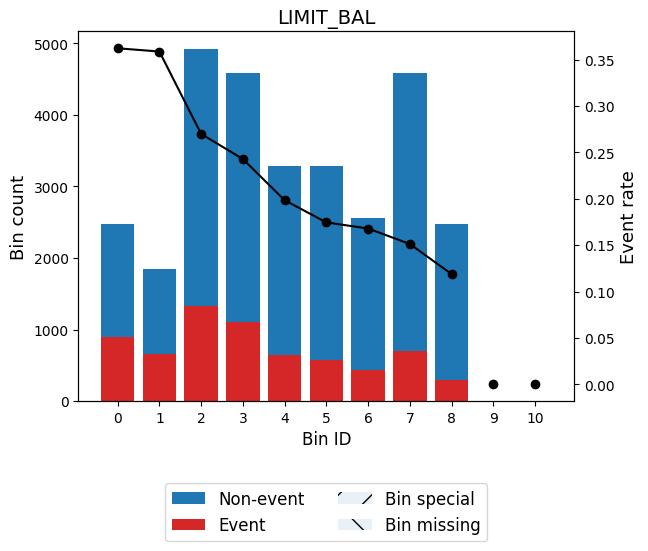

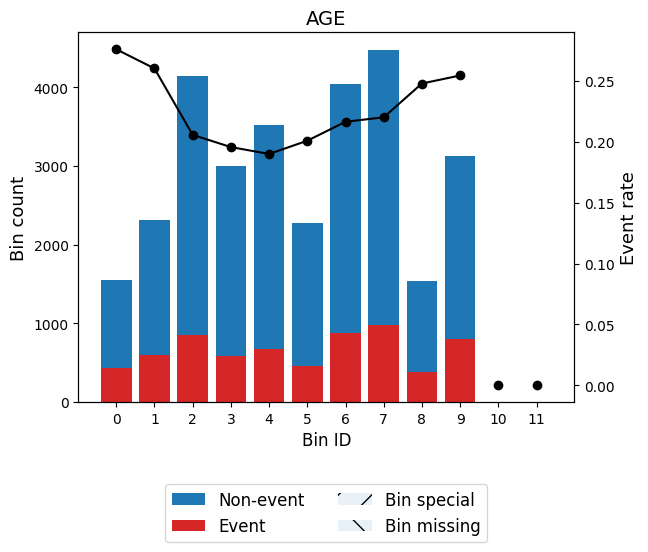

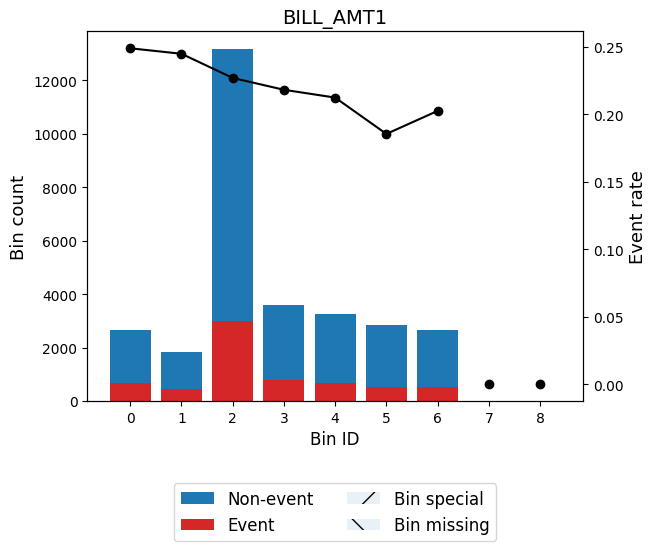

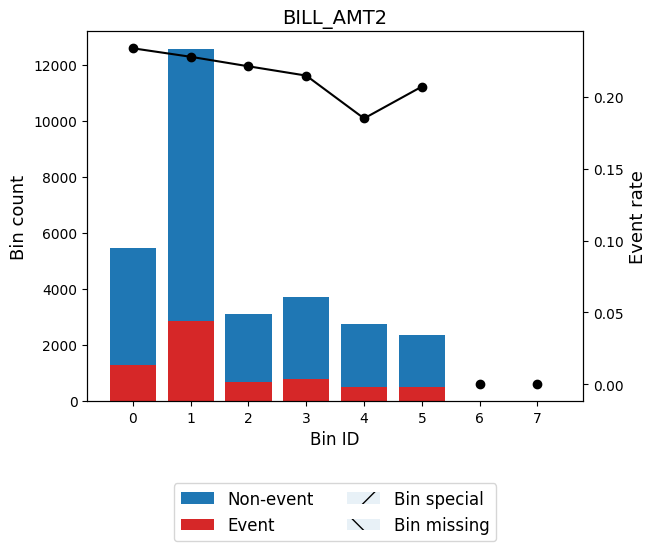

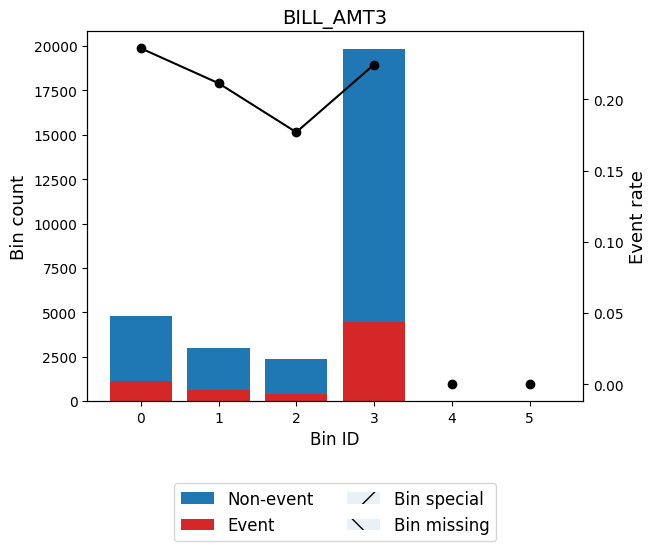

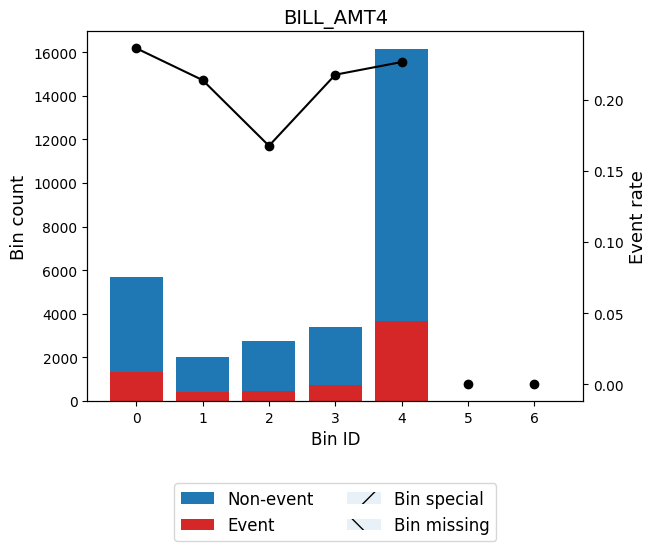

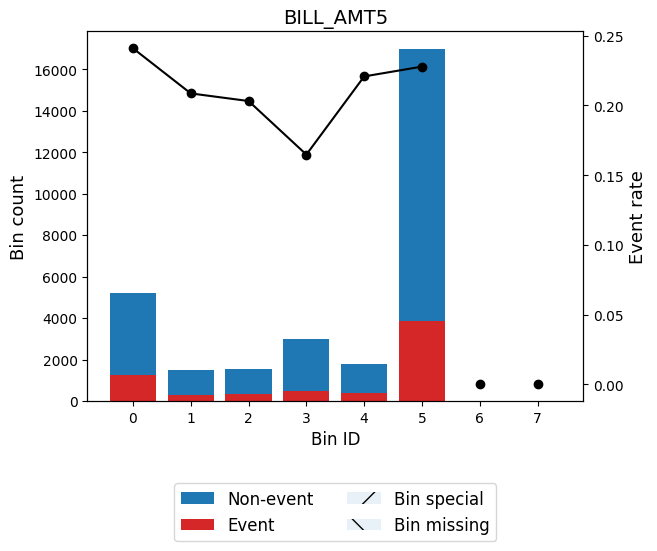

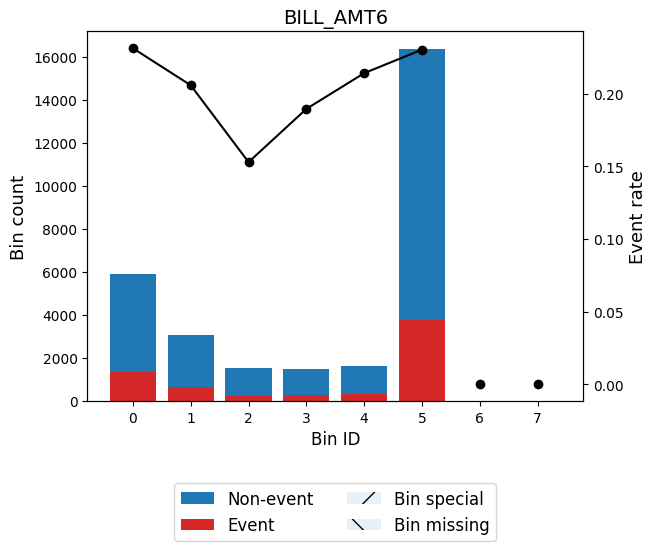

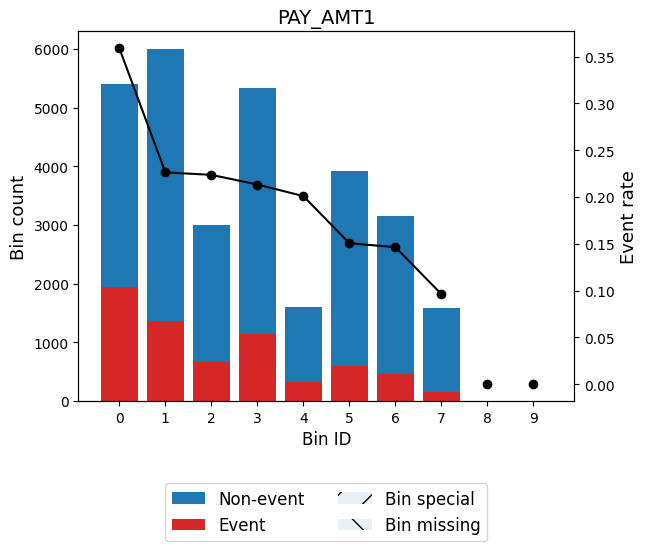

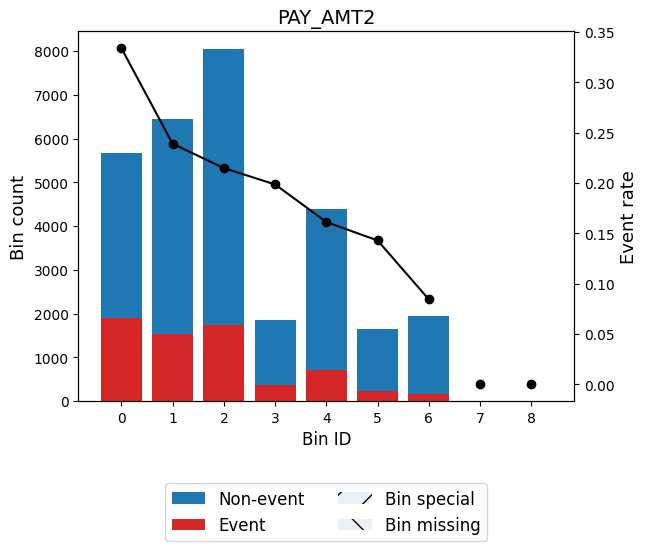

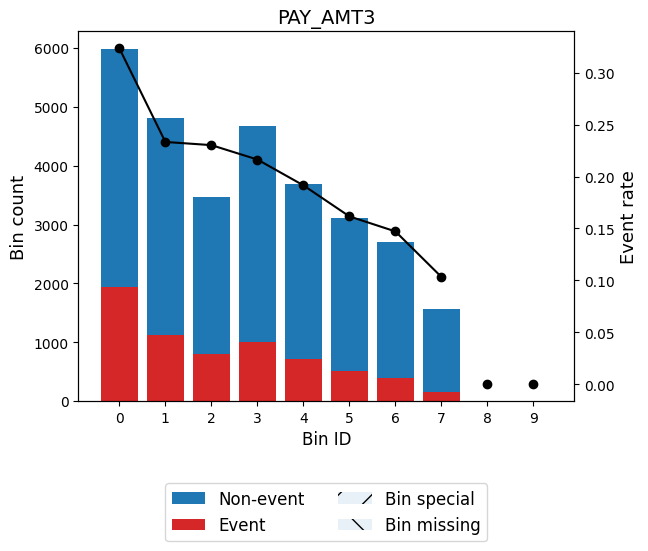

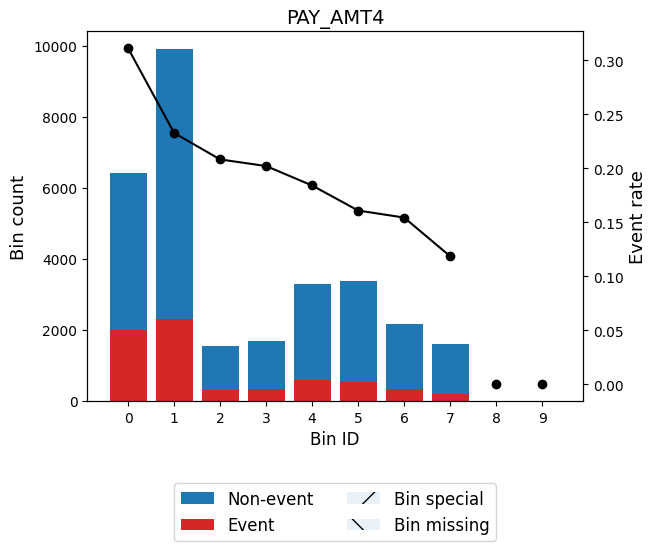

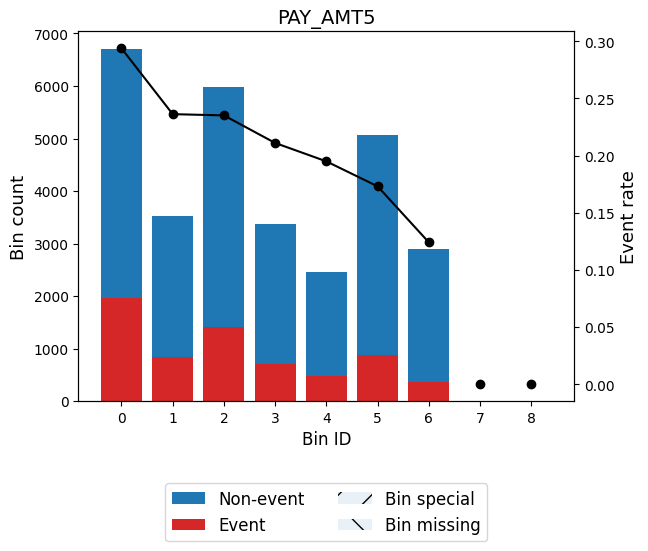

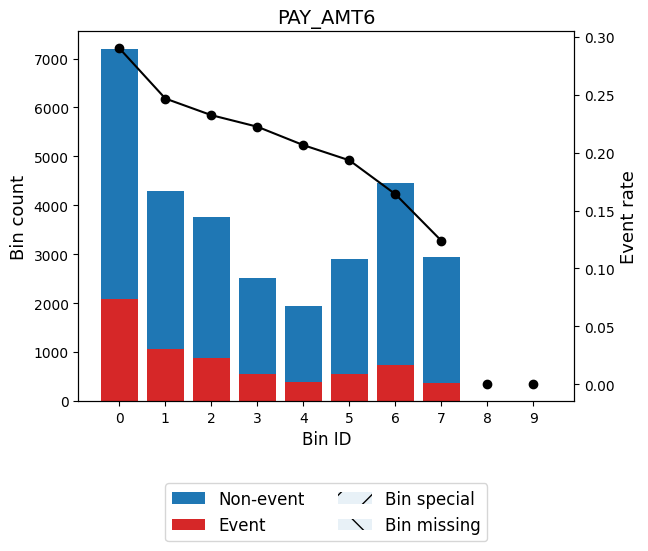

In [ ]:
# Imprime os gráficos com as taxas de evento por faixa de cada variável
y = credit.IsDef
num_tables = {}

for var_num in num:

  x_num = credit[var_num].values
  optb_num = OptimalBinning(name=var_num, dtype="numerical", solver="cp")
  optb_num.fit(x_num, y)
  binning_table = optb_num.binning_table
  num_tables[var_num] = binning_table.build()
  binning_table.plot(metric="event_rate")

In [ ]:
for num_var, table in num_tables.items():
  print(num_var)
  display(table)

LIMIT_BAL


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 25000.00)",2471,0.082367,1576,895,0.362202,-0.692865,0.046710,0.005725
1,"[25000.00, 45000.00)",1840,0.061333,1180,660,0.358696,-0.677657,0.033173,0.004069
2,"[45000.00, 75000.00)",4921,0.164033,3593,1328,0.269864,-0.263374,0.012204,0.001521
3,"[75000.00, 125000.00)",4580,0.152667,3468,1112,0.242795,-0.121269,0.002321,0.000290
4,"[125000.00, 165000.00)",3282,0.109400,2631,651,0.198355,0.137923,0.002001,0.000250
5,"[165000.00, 205000.00)",3284,0.109467,2711,573,0.174482,0.2955,0.008772,0.001093
6,"[205000.00, 245000.00)",2555,0.085167,2126,429,0.167906,0.341854,0.009007,0.001120
7,"[245000.00, 365000.00)",4591,0.153033,3897,694,0.151165,0.466803,0.029042,0.003598
8,"[365000.00, inf)",2476,0.082533,2182,294,0.118740,0.74573,0.036606,0.004473
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


AGE


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 23.50)",1558,0.051933,1128,430,0.275995,-0.294271,0.004861,6.054372e-04
1,"[23.50, 25.50)",2313,0.077100,1711,602,0.260268,-0.214111,0.003744,4.670743e-04
2,"[25.50, 28.50)",4142,0.138067,3290,852,0.205698,0.092369,0.001148,1.434024e-04
3,"[28.50, 30.50)",3000,0.100000,2413,587,0.195667,0.154914,0.002296,2.867239e-04
4,"[30.50, 33.50)",3521,0.117367,2852,669,0.190003,0.191305,0.004066,5.074846e-04
5,"[33.50, 35.50)",2275,0.075833,1818,457,0.200879,0.122122,0.001092,1.364663e-04
6,"[35.50, 39.50)",4047,0.134900,3171,876,0.216457,0.027749,0.000103,1.288350e-05
7,"[39.50, 45.50)",4475,0.149167,3490,985,0.220112,0.006328,0.000006,7.454144e-07
8,"[45.50, 48.50)",1537,0.051233,1156,381,0.247885,-0.148765,0.001181,1.474444e-04
9,"[48.50, inf)",3132,0.104400,2335,797,0.254470,-0.183775,0.003705,4.625161e-04


BILL_AMT1


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 91.50)",2644,0.088133,1986,658,0.248865,-0.154014,0.002180,0.000272
1,"[91.50, 782.50)",1826,0.060867,1379,447,0.244797,-0.132132,0.001102,0.000138
2,"[782.50, 34525.00)",13168,0.438933,10180,2988,0.226914,-0.032866,0.000478,0.000060
3,"[34525.00, 54406.00)",3585,0.119500,2803,782,0.218131,0.017904,0.000038,0.000005
4,"[54406.00, 90643.00)",3273,0.109100,2578,695,0.212343,0.05217,0.000293,0.000037
5,"[90643.00, 152362.00)",2842,0.094733,2315,527,0.185433,0.221277,0.004352,0.000543
6,"[152362.00, inf)",2662,0.088733,2123,539,0.202479,0.112183,0.001082,0.000135
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,30000,1.000000,23364,6636,0.221200,,0.009525,0.001189


BILL_AMT2


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1050.50)",5467,0.182233,4188,1279,0.233949,-0.072542,9.783379e-04,1.222654e-04
1,"[1050.50, 35018.50)",12573,0.419100,9706,2867,0.228028,-0.039209,6.513362e-04,8.141181e-05
2,"[35018.50, 51214.00)",3112,0.103733,2423,689,0.221401,-0.001167,1.412112e-07,1.765140e-08
3,"[51214.00, 92368.50)",3713,0.123767,2915,798,0.214921,0.036829,1.661537e-04,2.076804e-05
4,"[92368.50, 156337.00)",2766,0.092200,2254,512,0.185105,0.22345,4.316674e-03,5.384645e-04
5,"[156337.00, inf)",2369,0.078967,1878,491,0.207260,0.082832,5.292700e-04,6.613984e-05
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000e+00,0.000000e+00
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000e+00,0.000000e+00
Totals,,30000,1.000000,23364,6636,0.221200,,6.641913e-03,8.290673e-04


BILL_AMT3


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 464.50)",4790,0.159667,3660,1130,0.235908,-0.083441,0.001137,0.000142
1,"[464.50, 3114.50)",3004,0.100133,2369,635,0.211385,0.057911,0.000330,0.000041
2,"[3114.50, 7721.00)",2379,0.079300,1958,421,0.176965,0.278359,0.005668,0.000706
3,"[7721.00, inf)",19827,0.660900,15377,4450,0.224441,-0.018718,0.000233,0.000029
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,30000,1.000000,23364,6636,0.221200,,0.007369,0.000919


BILL_AMT4


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 787.50)",5675,0.189167,4334,1341,0.236300,-0.085612,0.001419,0.000177
1,"[787.50, 2512.50)",2043,0.068100,1606,437,0.213901,0.042882,0.000124,0.000015
2,"[2512.50, 7796.50)",2737,0.091233,2278,459,0.167702,0.343316,0.009727,0.001210
3,"[7796.50, 16645.00)",3399,0.113300,2659,740,0.217711,0.020368,0.000047,0.000006
4,"[16645.00, inf)",16146,0.538200,12487,3659,0.226620,-0.031189,0.000528,0.000066
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,30000,1.000000,23364,6636,0.221200,,0.011845,0.001475


BILL_AMT5


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 390.50)",5190,0.173000,3939,1251,0.241040,-0.111703,2.225630e-03,2.780592e-04
1,"[390.50, 1113.50)",1500,0.050000,1187,313,0.208667,0.074294,2.702592e-04,3.377463e-05
2,"[1113.50, 2501.50)",1565,0.052167,1247,318,0.203195,0.107758,5.875240e-04,7.340498e-05
3,"[2501.50, 8499.50)",2992,0.099733,2499,493,0.164773,0.36445,1.190573e-02,1.480034e-03
4,"[8499.50, 12542.50)",1784,0.059467,1390,394,0.220852,0.002021,2.427784e-07,3.034729e-08
5,"[12542.50, inf)",16969,0.565633,13102,3867,0.227886,-0.038401,8.430313e-04,1.053724e-04
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000e+00,0.000000e+00
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000e+00,0.000000e+00
Totals,,30000,1.000000,23364,6636,0.221200,,1.583242e-02,1.970676e-03


BILL_AMT6


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 420.50)",5890,0.196333,4527,1363,0.231409,-0.058316,0.000679,0.000085
1,"[420.50, 2658.00)",3074,0.102467,2441,633,0.205921,0.091006,0.000827,0.000103
2,"[2658.00, 5415.50)",1549,0.051633,1312,237,0.153002,0.452561,0.009251,0.001147
3,"[5415.50, 8814.00)",1508,0.050267,1222,286,0.189655,0.193565,0.001782,0.000222
4,"[8814.00, 12657.00)",1610,0.053667,1265,345,0.214286,0.040596,0.000087,0.000011
5,"[12657.00, inf)",16369,0.545633,12597,3772,0.230436,-0.052834,0.001545,0.000193
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,30000,1.000000,23364,6636,0.221200,,0.014171,0.001761


PAY_AMT1


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 21.50)",5411,0.180367,3469,1942,0.358899,-0.678539,0.097825,0.011999
1,"[21.50, 1604.50)",6000,0.200000,4642,1358,0.226333,-0.029555,0.000176,0.000022
2,"[1604.50, 2000.50)",3004,0.100133,2332,672,0.223702,-0.014464,0.000021,0.000003
3,"[2000.50, 3700.50)",5333,0.177767,4195,1138,0.213388,0.045934,0.000370,0.000046
4,"[3700.50, 4552.50)",1602,0.053400,1280,322,0.200999,0.121377,0.000760,0.000095
5,"[4552.50, 7821.00)",3924,0.130800,3333,591,0.150612,0.471125,0.025250,0.003127
6,"[7821.00, 17588.00)",3147,0.104900,2686,461,0.146489,0.503723,0.022916,0.002835
7,"[17588.00, inf)",1579,0.052633,1427,152,0.096263,0.980762,0.037437,0.004501
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


PAY_AMT2


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 91.00)",5665,0.188833,3774,1891,0.333804,-0.567657,0.070066,0.008643
1,"[91.00, 1602.50)",6459,0.215300,4916,1543,0.238891,-0.09992,0.002209,0.000276
2,"[1602.50, 3720.00)",8046,0.268200,6318,1728,0.214765,0.037751,0.000378,0.000047
3,"[3720.00, 4980.50)",1859,0.061967,1490,369,0.198494,0.137048,0.001119,0.000140
4,"[4980.50, 9903.00)",4380,0.146000,3674,706,0.161187,0.390734,0.019873,0.002468
5,"[9903.00, 15001.00)",1645,0.054833,1410,235,0.142857,0.533072,0.013293,0.001642
6,"[15001.00, inf)",1946,0.064867,1782,164,0.084275,1.126938,0.058102,0.006901
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,30000,1.000000,23364,6636,0.221200,,0.165041,0.020118


PAY_AMT3


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",5981,0.199367,4046,1935,0.323524,-0.521066,0.061704,0.007627
1,"[1.50, 1000.50)",4813,0.160433,3690,1123,0.233326,-0.069064,0.000780,0.000097
2,"[1000.50, 1600.50)",3461,0.115367,2664,797,0.230280,-0.051958,0.000316,0.000039
3,"[1600.50, 2928.50)",4667,0.155567,3657,1010,0.216413,0.028006,0.000121,0.000015
4,"[2928.50, 4641.50)",3691,0.123033,2984,707,0.191547,0.181302,0.003840,0.000479
5,"[4641.50, 7301.00)",3118,0.103933,2614,504,0.161642,0.387374,0.013919,0.001729
6,"[7301.00, 16884.00)",2711,0.090367,2312,399,0.147178,0.49822,0.019345,0.002393
7,"[16884.00, inf)",1558,0.051933,1397,161,0.103338,0.901991,0.032049,0.003876
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


PAY_AMT4


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",6408,0.213600,4415,1993,0.311017,-0.46332,0.051598,0.006393
1,"[0.50, 1900.50)",9904,0.330133,7600,2304,0.232633,-0.065185,0.001428,0.000178
2,"[1900.50, 2052.50)",1547,0.051567,1225,322,0.208145,0.077458,0.000303,0.000038
3,"[2052.50, 2864.00)",1698,0.056600,1355,343,0.202002,0.115139,0.000726,0.000091
4,"[2864.00, 4327.50)",3288,0.109600,2683,605,0.184002,0.230775,0.005461,0.000681
5,"[4327.50, 7509.50)",3389,0.112967,2844,545,0.160814,0.393494,0.015582,0.001935
6,"[7509.50, 15090.00)",2171,0.072367,1836,335,0.154307,0.442527,0.012435,0.001542
7,"[15090.00, inf)",1595,0.053167,1406,189,0.118495,0.74807,0.023712,0.002897
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


PAY_AMT5


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",6703,0.223433,4733,1970,0.293898,-0.382161,0.036034,0.004477
1,"[0.50, 715.50)",3517,0.117233,2686,831,0.236281,-0.085508,0.000878,0.000110
2,"[715.50, 1935.50)",5974,0.199133,4569,1405,0.235186,-0.07943,0.001284,0.000160
3,"[1935.50, 2927.50)",3378,0.112600,2665,713,0.211072,0.059791,0.000396,0.000049
4,"[2927.50, 3997.50)",2467,0.082233,1986,481,0.194974,0.159324,0.001995,0.000249
5,"[3997.50, 9986.50)",5060,0.168667,4184,876,0.173123,0.30497,0.014355,0.001788
6,"[9986.50, inf)",2901,0.096700,2541,360,0.124095,0.695522,0.037911,0.004646
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,30000,1.000000,23364,6636,0.221200,,0.092852,0.011479


PAY_AMT6


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",7193,0.239767,5106,2087,0.290143,-0.363998,0.034928,4.342004e-03
1,"[1.50, 925.50)",4292,0.143067,3233,1059,0.246738,-0.142602,0.003024,3.777312e-04
2,"[925.50, 1501.50)",3761,0.125367,2887,874,0.232385,-0.063794,0.000519,6.489702e-05
3,"[1501.50, 2000.50)",2509,0.083633,1951,558,0.222399,-0.006949,0.000004,5.057394e-07
4,"[2000.50, 2976.50)",1937,0.064567,1537,400,0.206505,0.087436,0.000482,6.017729e-05
5,"[2976.50, 4058.00)",2906,0.096867,2344,562,0.193393,0.169425,0.002649,3.307402e-04
6,"[4058.00, 9849.50)",4448,0.148267,3718,730,0.164119,0.36921,0.018138,2.254511e-03
7,"[9849.50, inf)",2954,0.098467,2588,366,0.123900,0.69732,0.038781,4.751794e-03
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00


In [ ]:
# imprime lista do IV de cada variável
ivs = {}
for num_var, table in num_tables.items():
  soma_IV = table.loc['Totals']['IV']
  ivs[num_var] = soma_IV

ivs

{'LIMIT_BAL': 0.17983606897027332,
 'AGE': 0.022201886786308505,
 'BILL_AMT1': 0.009524683452261234,
 'BILL_AMT2': 0.006641913094817542,
 'BILL_AMT3': 0.0073686699218705985,
 'BILL_AMT4': 0.011844941612451589,
 'BILL_AMT5': 0.015832416458833817,
 'BILL_AMT6': 0.014170739016679812,
 'PAY_AMT1': 0.1847560223674365,
 'PAY_AMT2': 0.16504107303774435,
 'PAY_AMT3': 0.13207401134022886,
 'PAY_AMT4': 0.11124475514045344,
 'PAY_AMT5': 0.09285231167652436,
 'PAY_AMT6': 0.0985258391679237}

# Análise Bivariada (Categóricas)

In [ ]:
cat = ['PAY_1', 'PAY_2', 'PAY_3',
        'PAY_4', 'PAY_5', 'PAY_6',
       'SEX', 'EDUCATION', 'MARRIAGE']

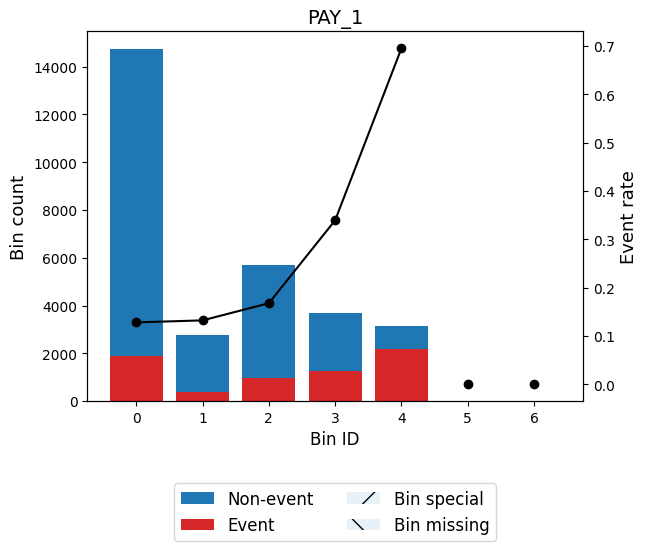

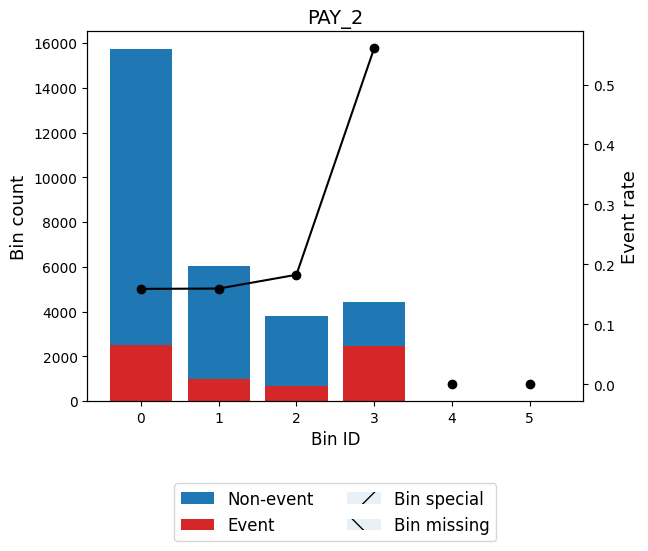

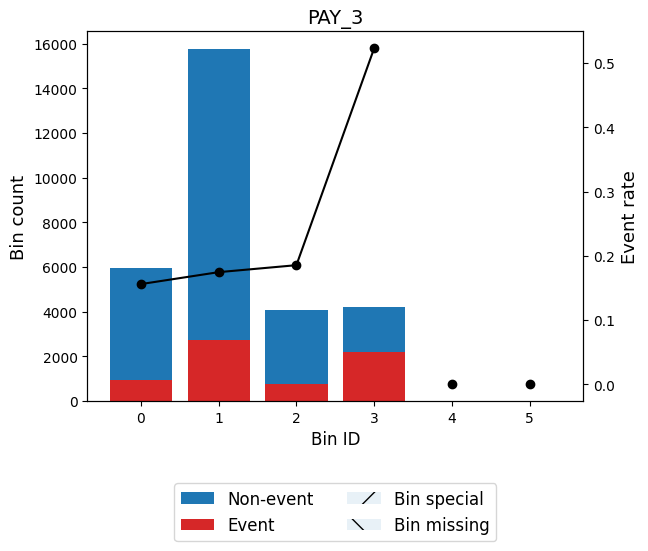

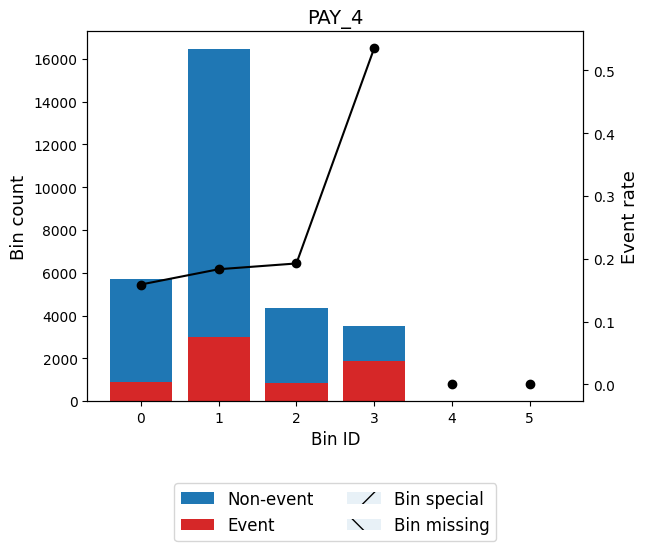

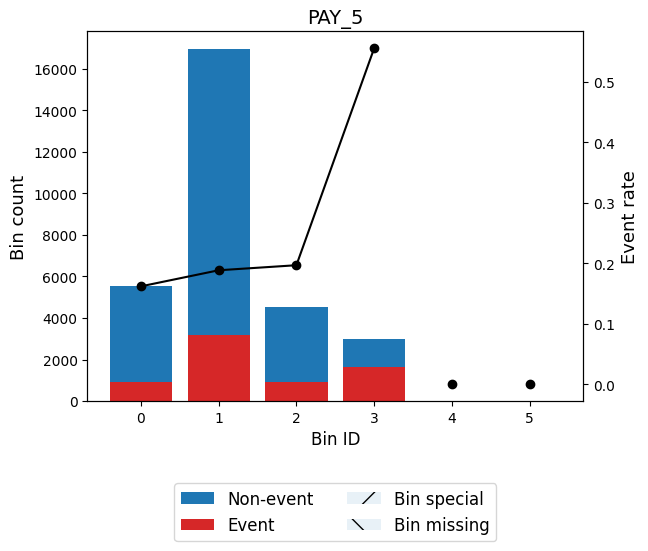

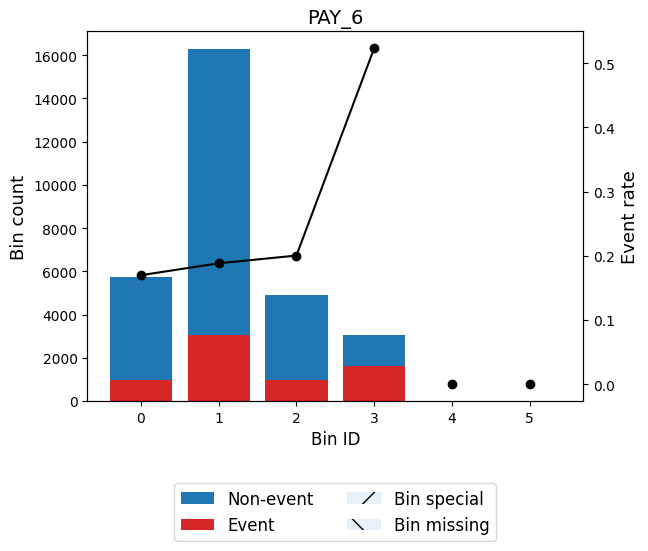

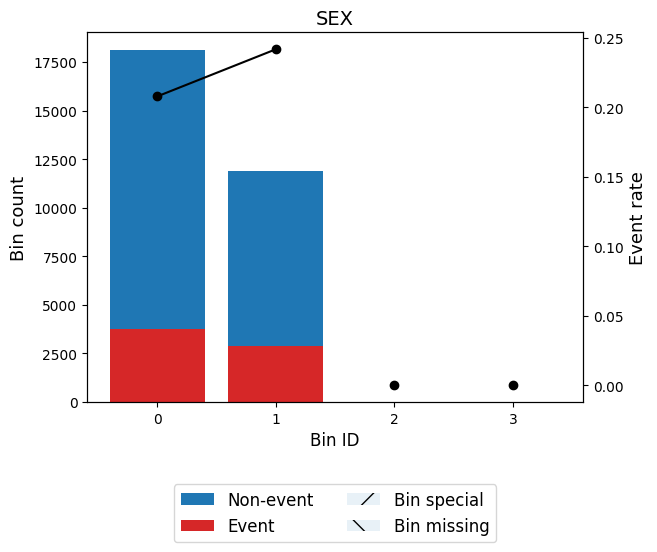

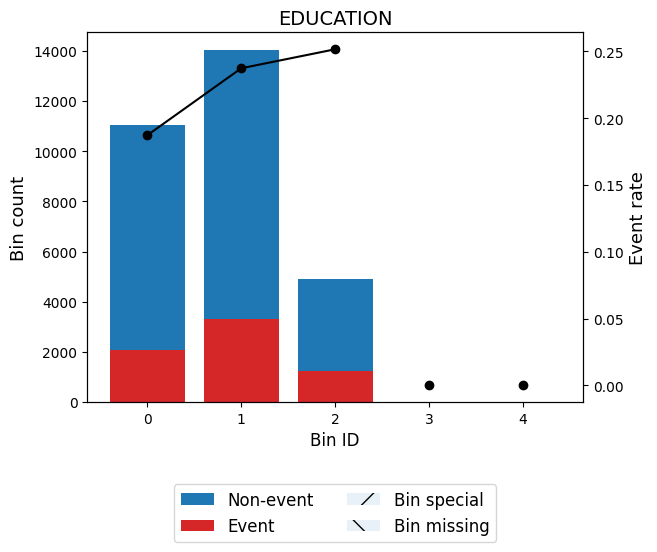

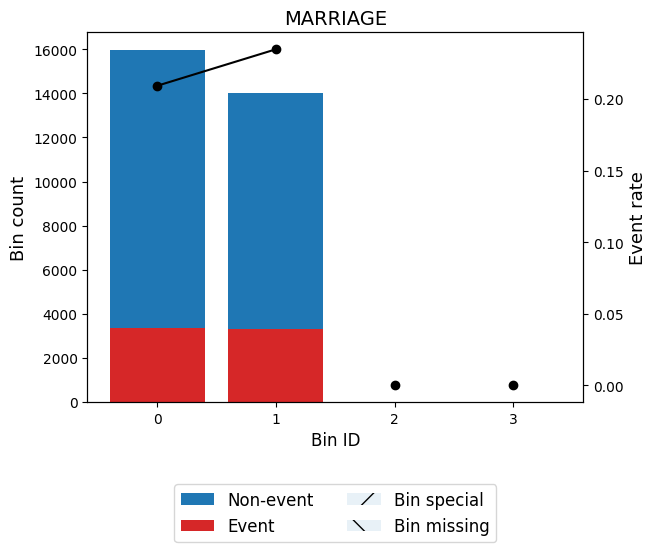

In [ ]:
y = credit.IsDef
cat_tables = {}

for var_cat in cat:

  x_cat = credit[var_cat].values
  optb_cat = OptimalBinning(name=var_cat, dtype="categorical", solver="cp")
  optb_cat.fit(x_cat, y)
  binning_table = optb_cat.binning_table
  cat_tables[var_cat] = binning_table.build()
  binning_table.plot(metric="event_rate")

In [ ]:
for cat_var, table in cat_tables.items():
  print(cat_var)
  display(table)

PAY_1


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[0],14737,0.491233,12849,1888,0.128113,0.659061,0.174941,0.021480
1,[-2],2759,0.091967,2394,365,0.132294,0.622137,0.029528,0.003633
2,[-1],5686,0.189533,4732,954,0.167781,0.342753,0.020144,0.002506
3,[1],3688,0.122933,2436,1252,0.339479,-0.593072,0.050058,0.006167
4,"[5, 6, 8, 4, 2, 3, 7]",3130,0.104333,953,2177,0.695527,-2.084775,0.598893,0.063702
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,30000,1.000000,23364,6636,0.221200,,0.873565,0.097488


PAY_2


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[8, 0]",15731,0.524367,13228,2503,0.159113,0.406159,0.076758,0.009529
1,[-1],6050,0.201667,5084,966,0.159669,0.402003,0.028956,0.003595
2,"[1, -2]",3810,0.127000,3114,696,0.182677,0.239627,0.006805,0.000849
3,"[4, 2, 5, 7, 3, 6]",4409,0.146967,1938,2471,0.560445,-1.501653,0.434601,0.049735
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,30000,1.000000,23364,6636,0.221200,,0.547120,0.063708


PAY_3


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[-1],5938,0.197933,5012,926,0.155945,0.430029,0.032242,0.003999
1,[0],15764,0.525467,13013,2751,0.174512,0.295297,0.042054,0.005238
2,"[-2, 1]",4089,0.136300,3331,758,0.185375,0.221657,0.006283,0.000784
3,"[2, 5, 3, 4, 6, 8, 7]",4209,0.140300,2008,2201,0.522927,-1.35046,0.331850,0.038591
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,30000,1.000000,23364,6636,0.221200,,0.412429,0.048612


PAY_4


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[-1],5687,0.189567,4783,904,0.158959,0.407307,0.027896,0.003463
1,[0],16455,0.548500,13439,3016,0.183288,0.235542,0.028432,0.003546
2,[-2],4348,0.144933,3511,837,0.192502,0.175145,0.004229,0.000528
3,"[6, 1, 8, 5, 2, 3, 4, 7]",3510,0.117000,1631,1879,0.535328,-1.400233,0.298732,0.034562
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,30000,1.000000,23364,6636,0.221200,,0.359289,0.042099


PAY_5


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[-1],5539,0.184633,4642,897,0.161943,0.385158,0.024461,0.003039
1,[0],16947,0.564900,13752,3195,0.188529,0.20091,0.021524,0.002686
2,[-2],4546,0.151533,3651,895,0.196876,0.147246,0.003150,0.000393
3,"[2, 5, 4, 3, 6, 7, 8]",2968,0.098933,1319,1649,0.555593,-1.481982,0.284598,0.032639
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,30000,1.000000,23364,6636,0.221200,,0.333734,0.038758


PAY_6


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[-1],5740,0.191333,4765,975,0.169861,0.327928,0.018699,0.002327
1,[0],16286,0.542867,13217,3069,0.188444,0.201465,0.020796,0.002595
2,[-2],4895,0.163167,3914,981,0.200409,0.125056,0.002463,0.000308
3,"[2, 5, 4, 3, 6, 7, 8]",3079,0.102633,1468,1611,0.523222,-1.351641,0.243208,0.028279
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,30000,1.000000,23364,6636,0.221200,,0.285164,0.033509


SEX


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[2],18112,0.603733,14349,3763,0.207763,0.079777,0.003757,0.000469
1,[1],11888,0.396267,9015,2873,0.241672,-0.115154,0.005423,0.000677
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,30000,1.000000,23364,6636,0.221200,,0.009180,0.001147


EDUCATION


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[4, 5, 1]",11053,0.368433,8984,2069,0.187189,0.209693,0.015253,0.001903
1,[2],14030,0.467667,10700,3330,0.237349,-0.091416,0.004008,0.000501
2,[3],4917,0.163900,3680,1237,0.251576,-0.168463,0.004869,0.000608
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,30000,1.000000,23364,6636,0.221200,,0.024129,0.003012


MARRIAGE


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[2],15964,0.532133,12623,3341,0.209283,0.070563,0.002597,0.000325
1,"[1, 3]",14036,0.467867,10741,3295,0.234753,-0.077025,0.002835,0.000354
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,30000,1.000000,23364,6636,0.221200,,0.005433,0.000679


In [ ]:
ivs_cat = {}
for cat_var, table in cat_tables.items():
  soma_IV = table.loc['Totals']['IV']
  ivs_cat[cat_var] = soma_IV

ivs_cat

{'PAY_1': 0.8735647030688639,
 'PAY_2': 0.5471201918586485,
 'PAY_3': 0.41242875740737167,
 'PAY_4': 0.3592893054135272,
 'PAY_5': 0.3337338127215284,
 'PAY_6': 0.2851644866061536,
 'SEX': 0.009179578460677327,
 'EDUCATION': 0.02412901582605573,
 'MARRIAGE': 0.005432682307501497}

# Treinamento

## SMOTE-NC

### One Hot Encoding (categóricas)

In [ ]:
credit_ohe = pd.get_dummies(credit, columns=cat)

In [ ]:
credit_ohe.columns

Index(['ID', 'LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'IsDef', 'PAY_1_-2',
       'PAY_1_-1', 'PAY_1_0', 'PAY_1_1', 'PAY_1_2', 'PAY_1_3', 'PAY_1_4',
       'PAY_1_5', 'PAY_1_6', 'PAY_1_7', 'PAY_1_8', 'PAY_2_-2', 'PAY_2_-1',
       'PAY_2_0', 'PAY_2_1', 'PAY_2_2', 'PAY_2_3', 'PAY_2_4', 'PAY_2_5',
       'PAY_2_6', 'PAY_2_7', 'PAY_2_8', 'PAY_3_-2', 'PAY_3_-1', 'PAY_3_0',
       'PAY_3_1', 'PAY_3_2', 'PAY_3_3', 'PAY_3_4', 'PAY_3_5', 'PAY_3_6',
       'PAY_3_7', 'PAY_3_8', 'PAY_4_-2', 'PAY_4_-1', 'PAY_4_0', 'PAY_4_1',
       'PAY_4_2', 'PAY_4_3', 'PAY_4_4', 'PAY_4_5', 'PAY_4_6', 'PAY_4_7',
       'PAY_4_8', 'PAY_5_-2', 'PAY_5_-1', 'PAY_5_0', 'PAY_5_2', 'PAY_5_3',
       'PAY_5_4', 'PAY_5_5', 'PAY_5_6', 'PAY_5_7', 'PAY_5_8', 'PAY_6_-2',
       'PAY_6_-1', 'PAY_6_0', 'PAY_6_2', 'PAY_6_3', 'PAY_6_4', 'PAY_6_5',
       'PAY_6_6', 'PAY_6_7', 'PAY_6_8', '

In [ ]:
credit_cat_ohe = credit_ohe.iloc[:, 16:]

credit_cat_ohe.columns

Index(['PAY_1_-2', 'PAY_1_-1', 'PAY_1_0', 'PAY_1_1', 'PAY_1_2', 'PAY_1_3',
       'PAY_1_4', 'PAY_1_5', 'PAY_1_6', 'PAY_1_7', 'PAY_1_8', 'PAY_2_-2',
       'PAY_2_-1', 'PAY_2_0', 'PAY_2_1', 'PAY_2_2', 'PAY_2_3', 'PAY_2_4',
       'PAY_2_5', 'PAY_2_6', 'PAY_2_7', 'PAY_2_8', 'PAY_3_-2', 'PAY_3_-1',
       'PAY_3_0', 'PAY_3_1', 'PAY_3_2', 'PAY_3_3', 'PAY_3_4', 'PAY_3_5',
       'PAY_3_6', 'PAY_3_7', 'PAY_3_8', 'PAY_4_-2', 'PAY_4_-1', 'PAY_4_0',
       'PAY_4_1', 'PAY_4_2', 'PAY_4_3', 'PAY_4_4', 'PAY_4_5', 'PAY_4_6',
       'PAY_4_7', 'PAY_4_8', 'PAY_5_-2', 'PAY_5_-1', 'PAY_5_0', 'PAY_5_2',
       'PAY_5_3', 'PAY_5_4', 'PAY_5_5', 'PAY_5_6', 'PAY_5_7', 'PAY_5_8',
       'PAY_6_-2', 'PAY_6_-1', 'PAY_6_0', 'PAY_6_2', 'PAY_6_3', 'PAY_6_4',
       'PAY_6_5', 'PAY_6_6', 'PAY_6_7', 'PAY_6_8', 'SEX_1', 'SEX_2',
       'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'EDUCATION_5', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3'],
      dtype='object')

### Scaler


In [14]:
from sklearn.preprocessing import StandardScaler

X = credit.iloc[:,1:-1].drop('SEX', axis=1)
y = credit['IsDef']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

In [15]:
X

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-1.136720,0.186432,-1.068797,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,-1.486041,...,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382
1,-0.365981,0.186432,0.849131,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,1.992316,...,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878
2,-0.597202,0.186432,0.849131,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,...,-0.482408,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122
3,-0.905498,0.186432,-1.068797,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,...,0.032846,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130
4,-0.905498,0.186432,-1.068797,2.334029,-0.874991,0.111736,-0.696663,0.188746,0.234917,0.253137,...,-0.161189,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.404759,1.461327,-1.068797,0.381275,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,...,2.326690,0.695474,-0.149259,-0.384392,0.171250,0.611048,-0.012648,-0.113564,0.013131,-0.237130
29996,-0.134759,1.461327,0.849131,0.815221,-0.874991,-0.723570,-0.696663,-0.666599,0.234917,0.253137,...,-0.627430,-0.532924,-0.577691,-0.652724,-0.231032,-0.103955,0.214255,-0.299828,-0.314136,-0.293382
29997,-1.059646,0.186432,0.849131,0.164303,3.574267,2.617654,1.809921,-0.666599,0.234917,0.253137,...,-0.638158,-0.347961,-0.324517,-0.327687,-0.341942,-0.256990,0.952725,-0.039964,-0.183229,-0.119001
29998,-0.674276,1.461327,-1.068797,0.598248,0.904712,-0.723570,0.138865,0.188746,0.234917,-0.616452,...,0.422373,0.147844,-0.468063,0.169130,4.844316,-0.109033,-0.229895,-0.185120,3.152536,-0.191904


## Train-Test Split

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

## Baseline Model

Treinamento de uma árvore de decisão com parâmetros default pra ver as métricas num modelo base: roc auc e ks.

## Gradient Boost

In [ ]:
gradient_booster = GradientBoostingClassifier(learning_rate=0.1).fit(X_oversample,y_oversample)
print(classification_report(y_test,gradient_booster.predict(X_test)))

In [ ]:
roc_auc_score(y_test, gradient_booster.predict_proba(X_test)[:, 1])

## Teste com Cross Validation

In [ ]:
## junta as categoricas ohe com as numericas
df_vars = pd.concat([credit_num_scaled, credit_cat_ohe], axis=1)

In [ ]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [ ]:
# cv = StratifiedKFold(n_splits=5)

# for fold, (train_index, test_index) in enumerate(cv.split(X,y)):
#     X_train = X[train_index]
#     y_train = y[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
#     X_test = X[test_index]
#     y_test = y[test_index]  # See comment on ravel and  y_train
#     smote = SMOTE(random_state = 42, sampling_strategy=.6)
#     X_train_oversampled, y_train_oversampled = smote.fit_sample(X_train, y_train)
#     gradient_booster = GradientBoostingClassifier(learning_rate=0.1)
#     # model.fit(X_train_oversampled, y_train_oversampled )
#     # y_pred = model.predict(X_test)
#     # print(f'For fold {fold}:')
#     # print(f'Accuracy: {model.score(X_test, y_test)}')
#     # print(f'f-score: {f1_score(y_test, y_pred)}')

In [ ]:
# print(kf.split(X))

In [ ]:
# for i, (train_index, test_index) in enumerate(kf.split(X)):
#   print(f"Fold {i}:")
#   print(f"  Train: index={train_index}")
#   print(f"  Test:  index={test_index}")

## Pipeline

In [ ]:
steps = [
         ('smote', SMOTE()),
         ('gbt', GradientBoostingClassifier())
        ]

param_grid = {
              'smote__sampling_strategy': [0.5, 0.6, 0.7],
              # 'lr__C': [0.1, 1, 10],
              # 'lr__penalty': ['l1', 'l2'],
              'gbt__learning_rate': [0.01, 0.05, 0.1],
              'gbt__max_depth': [3, 5, 8],
              'gbt__n_estimators': [50, 100, 150, 250],
              'gbt__max_features': ['sqrt', 'log2']
}

pipeline = Pipeline(steps)

gcv = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=False)
gcv.fit(X_train, y_train)
gcv.best_score_

0.7807377251478096

In [ ]:
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

y_pred = gcv.predict(X_test)
pred_df = pd.DataFrame({'y': y_test,'y_pred': y_pred})
auc = roc_auc_score(y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [ ]:
gcv.best_estimator_

Pipeline(steps=[('smote', SMOTE(sampling_strategy=0.5)),
                ('gbt',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                                            max_features='log2',
                                            n_estimators=250))])

In [ ]:
proba = gcv.predict_proba(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [ ]:
[row[1] for row in proba]

[0.2670518447787438,
 0.19563175962888799,
 0.3599080639250902,
 0.19530708733734797,
 0.17621872349571394,
 0.17598849414659987,
 0.40673855843114765,
 0.18372292395502907,
 0.3366557002201769,
 0.19292901141621038,
 0.14308866371761658,
 0.6061253937058279,
 0.1544792881629387,
 0.15247485830115576,
 0.6838512459572031,
 0.18839415038628016,
 0.2682318851634944,
 0.14855343746007638,
 0.13575161121457904,
 0.27059754528619573,
 0.28828442470901466,
 0.2326985547749359,
 0.21047258323420825,
 0.5543307286220199,
 0.24029452762961137,
 0.1280374531523851,
 0.19602048173207404,
 0.24234557328339432,
 0.22151009895543694,
 0.25938298325555553,
 0.21268614929303256,
 0.2886121118319935,
 0.5568862679675765,
 0.14680924805120446,
 0.3256915852970556,
 0.16531959695488763,
 0.14888033479472643,
 0.1472213908665873,
 0.24167772756318287,
 0.7710996982901895,
 0.20073406549177308,
 0.7763608054310354,
 0.1685460964954432,
 0.3375683168790684,
 0.24792126036173215,
 0.4354715932101101,
 0.3125

In [ ]:
score_df = pd.DataFrame()

(3000,)

In [ ]:
auc

0.6711116727182703

In [ ]:
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

y_pred = gcv.predict(X_test)
pred_df = pd.DataFrame({'y': y_test,'y_pred': y_pred})
auc = roc_auc_score(y_test, y_pred)

In [ ]:
auc

0.6783091269186333

In [ ]:
gcv.best_estimator_

Pipeline(steps=[('oversampling', SMOTE(random_state=42, sampling_strategy=0.6)),
                ('clf',
                 GradientBoostingClassifier(learning_rate=0.05,
                                            n_estimators=250))])

In [ ]:
gcv.best_params_

{'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 250}

In [ ]:
model = Pipeline([
                  ('sampling', SMOTE()),
                  ('classification', clf)
                  ])

classifiers = [
              ('KNearestNeighbors', KNeighborsClassifier()),
              ('Gradient Boosting Classifier', GradientBoostingClassifier()),
              ]

params = [
          {'sampling__sampling_strategy': [0.6], 'sampling__random_state': [42]},
          {'classification__n_neighbors': (10, 15, 25)},
          {'classification__n_estimators': (80, 100, 150, 200), 'classification__min_samples_split': (5, 7, 10, 20)}
          ]

score={'AUC':'roc_auc',
        'RECALL':'recall',
        'PRECISION':'precision',
        'F1':'f1'}


gcv = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=score, n_jobs=12, refit='F1',
                    return_train_score=True)
gcv.fit(X, y)

ValueError: ignored

In [ ]:
classifiers = [
              ('KNearestNeighbors', KNeighborsClassifier()),
              ('Gradient Boosting Classifier', GradientBoostingClassifier()),
              ]

In [ ]:
params = [
          {'sampling__sampling_strategy': [0.6], 'sampling__random_state': [42]},
          {'classification__n_neighbors': (10, 15, 25)},
          {'classification__n_estimators': (80, 100, 150, 200), 'classification__min_samples_split': (5, 7, 10, 20)}
          ]

# params = {'sampling__sampling_strategy': [0.6],
#           'sampling__random_state': [42],
#           "clf__loss":["deviance"],
#           "clf__learning_rate": [0.001, 0.05, 0.1, 0.15],
#           # "clf__min_samples_split": np.linspace(0.1, 0.5, 12),
#           # "clf__min_samples_leaf": np.linspace(0.1, 0.5, 12),
#           "clf__max_depth":[3, 5, 8],
#           "clf__max_features":["log2","sqrt"],
#           "clf__criterion": ["friedman_mse"],
#           "clf__subsample":[0.5, 0.8, 1.0],
#           "clf__n_estimators":[10]
#           }

In [ ]:
for param, classifier in tqdm(zip(params, classifiers)):
    print("Working on {}...".format(classifier[0]))
    clf = imb_pipeline(classifier[1], X, y, param)
    print("Best parameter for {} is {}".format(classifier[0], clf.best_params_))
    print("Best `F1` for {} is {}".format(classifier[0], clf.best_score_))
    print('-'*50)
    print('\n')


# for param in zip(params):
#     clf = imb_pipeline(X, y, params)
#     print("Best parameter for GB is {}".format(clf.best_params_))
#     print("Best `F1` for GB is {}".format(clf.best_score_))
#     print('-'*50)
#     print('\n')

0it [00:00, ?it/s]

Working on KNearestNeighbors...


1it [01:52, 112.01s/it]

Best parameter for KNearestNeighbors is {'sampling__random_state': 42, 'sampling__sampling_strategy': 0.6}
Best `F1` for KNearestNeighbors is 0.44677934380912293
--------------------------------------------------


Working on Gradient Boosting Classifier...


1it [01:55, 115.30s/it]


ValueError: ignored

In [ ]:
for param in zip(params):
  print(param)

({'sampling__sampling_strategy': [0.6], 'sampling__random_state': [42]},)
({'classification__n_neighbors': (10, 15, 25)},)
({'classification__n_estimators': (80, 100, 150, 200), 'classification__min_samples_split': (5, 7, 10, 20)},)


In [ ]:
# for param, classifier in zip(params, classifiers):
#     print("Working on {}...".format(classifier[0]))
#     clf = imb_pipeline(classifier[1], X_scaled, y, param)
#     print("Best parameter for {} is {}".format(classifier[0], clf.best_params_))
#     print("Best `F1` for {} is {}".format(classifier[0], clf.best_score_))
#     print('-'*50)
#     print('\n')